In [23]:
#import dependencies

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential
from keras import layers
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import yfinance as yf
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import numpy as np
import pandas as pd


the following cells is a test from an article : https://drlee.io/advanced-stock-pattern-prediction-using-lstm-with-the-attention-mechanism-in-tensorflow-a-step-by-143a2e8b0e95

In [3]:
aapl_data = yf.download('AAPL', start='2010-01-01', end='2024-01-01')

aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461977,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473148,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370186,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358408,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400681,447610800


In [2]:
#test with SP500 
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = sp500['Symbol'].tolist()

all_data = yf.download(tickers, start='2010-01-01', end='2024-01-01')

[**********************94%%*******************   ]  472 of 503 completed

$BF.B: possibly delisted; No price data found  (1d 2010-01-01 -> 2024-01-01)


[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['SOLV', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1262322000, endDate = 1704085200")
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2010-01-01 -> 2024-01-01)')


In [10]:
all_data

Price        Adj Close                                                 \
Ticker               A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2010-01-04   20.122225   4.496876    6.461977         NaN         NaN   
2010-01-05   19.903641   5.005957    6.473148         NaN         NaN   
2010-01-06   19.832935   4.798555    6.370186         NaN         NaN   
2010-01-07   19.807220   4.939965    6.358408         NaN         NaN   
2010-01-08   19.800791   4.845692    6.400681         NaN         NaN   
...                ...        ...         ...         ...         ...   
2023-12-22  139.108368  14.310000  193.091385  152.053635  140.800003   
2023-12-26  139.347549  14.110000  192.542831  151.739594  138.720001   
2023-12-27  139.357529  13.990000  192.642548  151.994751  136.550003   
2023-12-28  139.307709  13.980000  193.071426  151.867172  137.000000   
2023-12-29  138.804504  13.740000  192.024185  152.083069  136.139999   

Price                                                                  ...  \
Ticker             ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                   ...   
2010-01-04   18.952166   7.994444   32.212475   37.090000   22.530375  ...   
2010-01-05   18.799042   7.967778   32.411552   37.700001   22.494808  ...   
2010-01-06   18.903442   7.933333   32.756092   37.619999   22.452116  ...   
2010-01-07   19.060038   7.886667   32.725483   36.889999   22.274273  ...   
2010-01-08   19.157484   7.871111   32.595306   36.689999   22.402317  ...   
...                ...        ...         ...         ...         ...  ...   
2023-12-22  107.970337  73.839996  351.798248  598.750000  196.175598  ...   
2023-12-26  108.168404  73.510002  350.785828  598.260010  197.937286  ...   
2023-12-27  108.722961  73.540001  351.172943  596.080017  198.415039  ...   
2023-12-28  109.327026  74.059998  348.959625  595.520020  199.300873  ...   
2023-12-29  109.000237  74.269997  348.284729  596.599976  197.628738  ...   

Price       Volume                                                           \
Ticker         WTW       WY     WYNN      XEL       XOM        XYL      YUM   
Date                                                                          
2010-01-04  348017  1832400  4741400  2670400  27809100        NaN  2962274   
2010-01-05  339523  1724500  5644300  4321400  30174700        NaN  3298757   
2010-01-06  585049  2254400  2738800  2164500  35044700        NaN  4178981   
2010-01-07  328689  1420700  2388500  3041700  27192100        NaN  2452472   
2010-01-08  279388  1310000  1539800  1599100  24891800        NaN  3772392   
...            ...      ...      ...      ...       ...        ...      ...   
2023-12-22  328600  2253500  1170500  2429300  12921800   829300.0   991500   
2023-12-26  296900  2542300  1150000  2147500  16835100   440300.0   627500   
2023-12-27  323300  2109200  1142200  2865900  14558800  1007700.0  1050400   
2023-12-28  265200  2586100  1233000  2421900  16329300   709100.0   882500   
2023-12-29  336900  3079100  1144800  2813300  17741400   698900.0  1196800   

Price                                   
Ticker          ZBH    ZBRA        ZTS  
Date                                    
2010-01-04   805872  168800        NaN  
2010-01-05  1769643  168800        NaN  
2010-01-06  1315619  385300        NaN  
2010-01-07  1734005  183600        NaN  
2010-01-08  2213985  266500        NaN  
...             ...     ...        ...  
2023-12-22  1337800  225900  1548400.0  
2023-12-26  1870700  220000   814600.0  
2023-12-27  1058600  275700   766400.0  
2023-12-28   662200  193900   880100.0  
2023-12-29   849600  251300  1007200.0  

[3522 rows x 3018 columns]

In [3]:
all_data = all_data['Adj Close']

<Axes: >

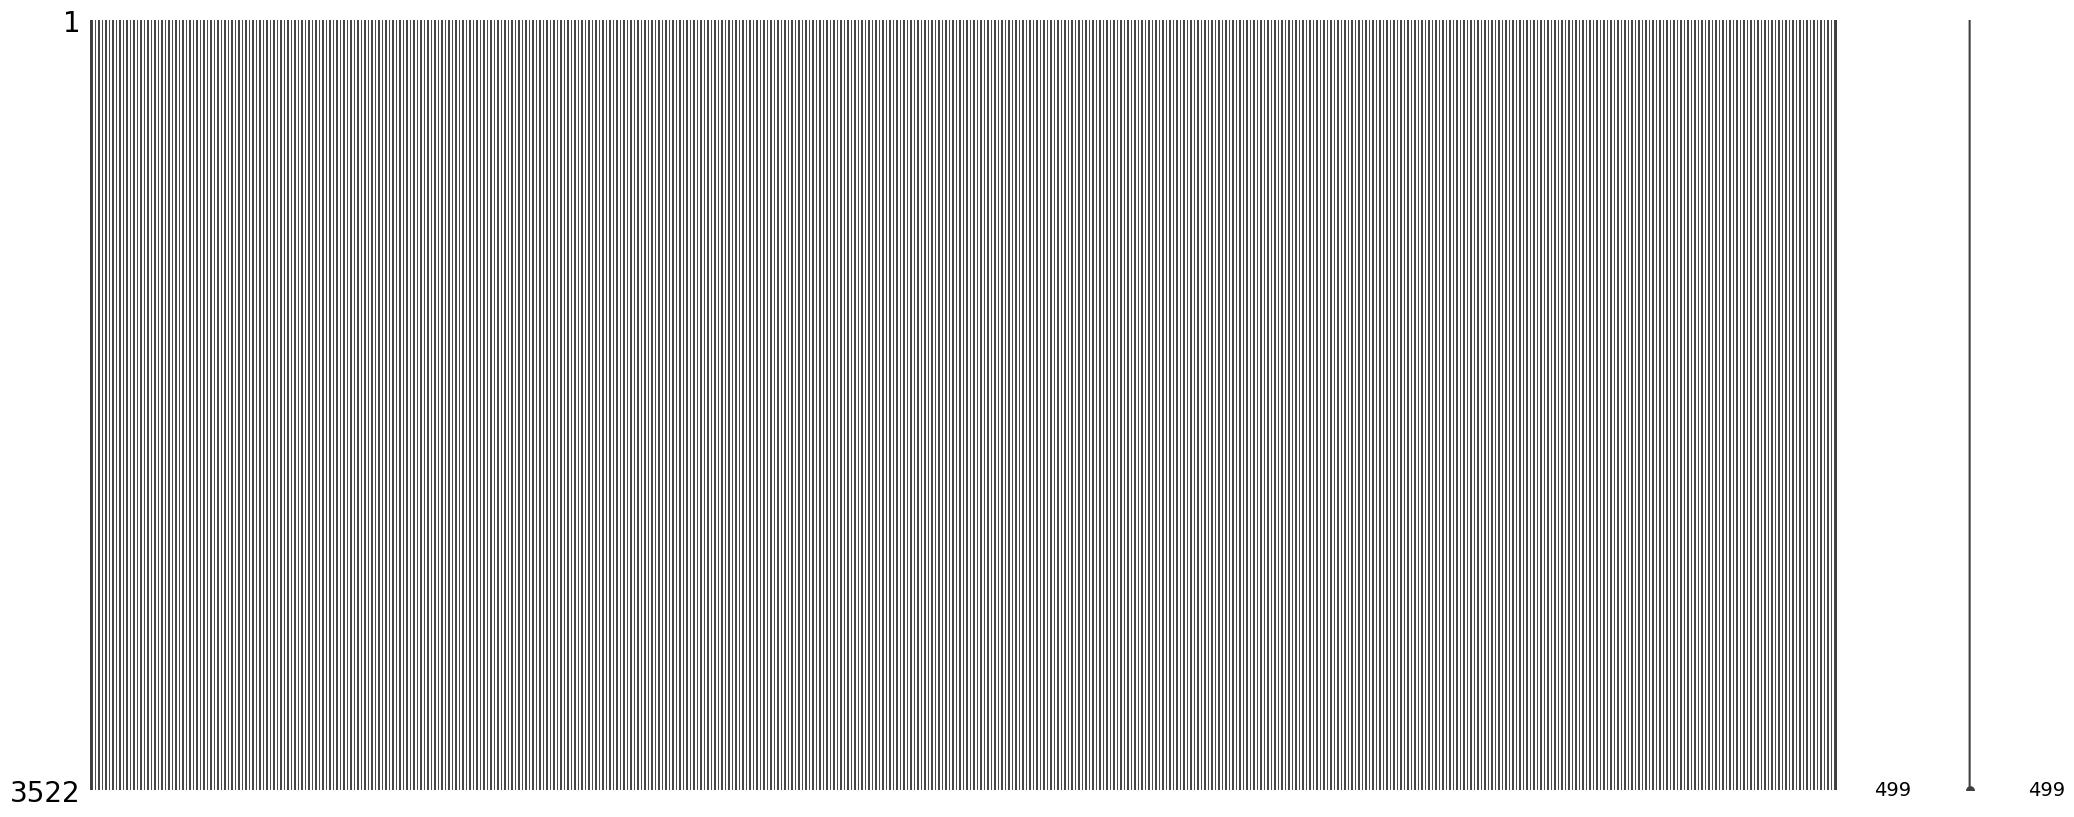

In [18]:
msno.matrix(all_data)

In [4]:
all_data = all_data.dropna(axis=1, how='all')

In [ ]:
cur.execute(
    sql.SQL("insert into {} values (%s, %s)")
        .format(sql.Identifier('my_table')),
    [10, 20])

In [5]:
all_data = all_data.fillna(0.0)

In [19]:
x=[]
y=[]

scaler = MinMaxScaler(feature_range=(0,1))

for stock in all_data.columns:
    stock_data = all_data[stock].values.reshape(-1,1)
    stock_data_scaled = scaler.fit_transform(stock_data)

    for i in range (60, len(stock_data_scaled)):
        x.append(stock_data_scaled[i-60:i, 0 ])
        y.append(stock_data_scaled[i, 0])

x = np.array(x)
y= np.array(y)

x= x.reshape(x.shape[0], x.shape[1], 1)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1382030, 60, 1)
x_test shape: (345508, 60, 1)
y_train shape: (1382030,)
y_test shape: (345508,)


In [28]:
import pickle
# Create an empty list to hold all sequences and targets
x = []
y = []
stock_ids = []

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
label_encoder = LabelEncoder()

# Generate one-hot encodings for stock identifiers
stock_names = all_data.columns.values
label_encoder_fit = label_encoder.fit(stock_names)
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder_fit, file)
stock_name_to_int = label_encoder_fit.transform(stock_names)
stock_name_to_int_dict = {stock: stock_int for stock, stock_int in zip(all_data.columns, stock_name_to_int)}
print('stock_name_to_one_hot done')
# Loop through each stock column
for stock in all_data.columns:
    # Scale the adjusted closing values
    stock_data = all_data[stock].values.reshape(-1,1)
    stock_data_scaled = scaler.fit_transform(stock_data)
    
    # Create sequences and targets
    for i in range(60, len(stock_data_scaled)):
        x.append(stock_data_scaled[i-60:i, 0])
        y.append(stock_data_scaled[i, 0])
        stock_ids.append(stock_name_to_int_dict[stock])

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)
stock_ids = np.array(stock_ids)
print('x, y, stock_ids done')
# Reshape x to have the required shape for LSTM (number of samples, time steps, number of features)
x = x.reshape((x.shape[0], x.shape[1], 1))
print('reshape done')
# Reshape stock_ids to match the shape of x (number of samples, 1)
stock_ids = stock_ids.reshape(-1, 1)

# Concatenate the integer-encoded stock identifiers to each sequence
x_with_stock_ids = np.concatenate((x, stock_ids.repeat(x.shape[1], axis=1).reshape(x.shape[0], x.shape[1], 1)), axis=2)

x_with_stock_ids = np.array(x_with_stock_ids)
print('x_with_stock_ids done')
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_with_stock_ids, y, test_size=0.2, random_state=42)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

stock_name_to_one_hot done
x, y, stock_ids done
reshape done
x_with_stock_ids done
x_train shape: (1382030, 60, 2)
x_test shape: (345508, 60, 2)
y_train shape: (1382030,)
y_test shape: (345508,)


In [16]:
import os
os.environ["WANDB_NOTEBOOK_NAME"] = "Exploratory_analysis.ipynb"

In [29]:
wandb.init(
    # set the wandb project where this run will be logged
    project="trading_dash",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "dropout": 0.2,
    "patience": 5,
    "epochs": 50,
    "LTSM":4
    }
)



# Define the model
model = Sequential([
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),  # Add dropout after the first LSTM layer
    layers.BatchNormalization(),  # Add batch normalization after the dropout layer
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),  # Add dropout after the second LSTM layer
    layers.BatchNormalization(),  # Add batch normalization after the dropout layer
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),  # Add dropout after the second LSTM layer
    layers.BatchNormalization(),  # Add batch normalization after the dropout layer
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),  # Add dropout after the second LSTM layer
    layers.BatchNormalization(),  # Add batch normalization after the dropout layer
    layers.Flatten(),
    layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='best_trading_model_3.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint, WandbMetricsLogger()])

model.save('final_trading_model_5.keras')
wandb.finish()

Epoch 1/50
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0464
Epoch 1: val_loss improved from inf to 0.00557, saving model to best_trading_model_3.keras
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 3101s 72ms/step - loss: 0.0464 - val_loss: 0.0056
Epoch 2/50
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 8.8209e-04
Epoch 2: val_loss did not improve from 0.00557
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 3175s 74ms/step - loss: 8.8209e-04 - val_loss: 0.0070
Epoch 3/50
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 7.3656e-04
Epoch 3: val_loss did not improve from 0.00557
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 3175s 74ms/step - loss: 7.3656e-04 - val_loss: 0.0113
Epoch 4/50
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 6.1456e-04
Epoch 4: val_loss did not improve from 0.00557
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 3157s 73ms/step - loss: 6.1456e-04 - val_loss: 0.0080
Epoch 5/50
43189/43189 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 5.5350e-04
Epoch 5: val_loss did not improve from 0.00557
4

KeyboardInterrupt: 

In [116]:
model = Sequential([
    layers.LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    layers.Dropout(0.2),  # Add dropout after the first LSTM layer
    layers.BatchNormalization(),  # Add batch normalization after the dropout layer
    layers.LSTM(units=50, return_sequences=True),
    layers.Dropout(0.2),  # Add dropout after the second LSTM layer
    layers.BatchNormalization(),  # Add batch normalization after the dropout layer
    layers.Flatten(),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')



e:\Data_Science\Perso_project\Trading_prediction\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [117]:
model.summary()

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_101 (LSTM)                 │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 60, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_102 (LSTM)                 │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 60, 50)         │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │         3,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,001 (132.82 KB)

 Trainable params: 33,801 (132.04 KB)

 Non-trainable params: 200 (800.00 B)

In [119]:
from keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(x_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])



Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 1.3030 - val_loss: 0.1112
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.4929 - val_loss: 0.0943
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3774 - val_loss: 0.2515
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3340 - val_loss: 0.2861
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3633 - val_loss: 0.6185
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3616 - val_loss: 0.3023
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3706 - val_loss: 0.0149
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1648 - val_loss: 0.0610
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1860 - val_loss: 0.0859
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1824 - val_loss: 0.1458
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1563 - val_loss: 0.0016
Epoch 12/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

In [120]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(x_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074
Test Loss:  0.007656436413526535


In [121]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Mean Absolute Error:  0.08170493543219252
Root Mean Square Error:  0.08750106137148018


e:\Data_Science\Perso_project\Trading_prediction\.conda\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

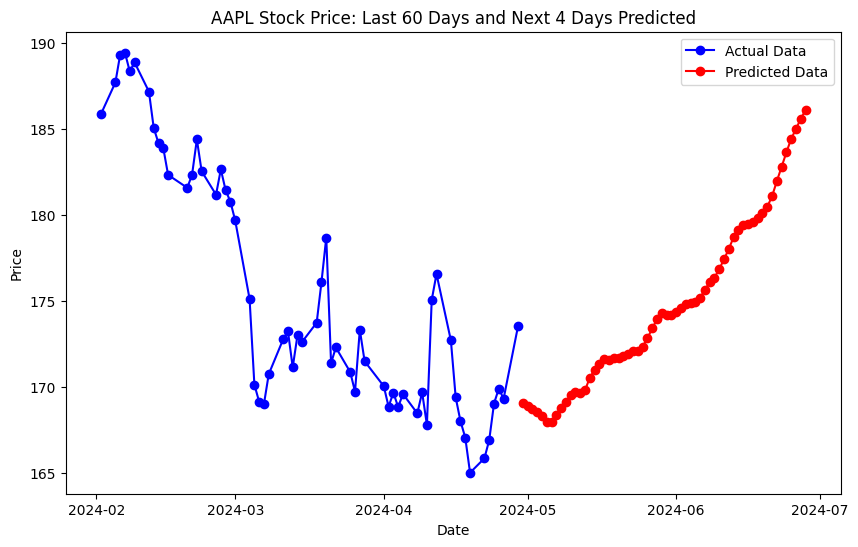

In [123]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='180d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(60):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=60)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()